### Model selection and evaluation

In this notebook, we will explore the use of cross-validation to select the best model and evaluate its performance.

We will use the same dataset as in the previous notebook.



### 1 - First, we load the dataset and split it into a training and a test set.


In [1]:
import pandas as pd

df = pd.read_csv('../src/data/processed/dataset.csv')
df.head()

,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,category_bus,category_entertainment,category_lifestyle,...,pct_positive_words,number_no_stopwords,average_bias_negative_words,number_images,pct_negative_words,degree_of_subjectivity,degree_of_sentiment,average_word_length,number_of_keywords,views
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.072544,1.0,-0.231548,20,0.012856,0.495945,0.266534,4.694215,8,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.049853,1.0,-0.220150,1,0.039589,0.473285,0.062227,4.620235,6,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.065491,1.0,-0.144643,1,0.010076,0.374314,0.212488,5.445844,6,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.061798,1.0,-0.372619,12,0.014045,0.435975,0.176738,4.471910,10,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017241,1.0,0.000000,1,0.000000,0.588636,0.159091,4.798851,8,0


In [2]:
#load column names from json file
import json

with open('../src/data/processed/features.json') as f:
    columns_name = json.load(f)
    f.close()


In [3]:
#declare target column name
target_col = 'views'

# X = df.drop(target_col, axis=1)
X = df[columns_name]
y = df[target_col]


Como estrategia de validacion, elijo una combinacion de las mas conocidas, separando el dataset en 3 grupo, uno de los cuales sera el de test, y los otros dos seran el de train y el de validacion. El de train se usara para entrenar el modelo, y el de validacion para evaluarlo. El de test se usara para evaluar el modelo final, una vez que se haya elegido el mejor modelo.

En este caso, elijo un 60% para train, un 20% para validacion y un 20% para test.

La validacion durante el entrenamiento se hara con la tecnica de validacion cruzada, que consiste en dividir el dataset de train en k subconjuntos, y entrenar el modelo k veces, cada vez con un subconjunto distinto. El resultado final sera la media de los resultados de las k iteraciones.

Mas informacion sobre la validacion cruzada en el siguiente enlace:

https://scikit-learn.org/stable/modules/cross_validation.html

In [4]:
#split dataset into train, test and validation

from sklearn.model_selection import train_test_split

# split data into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col])

# split train into train and validation
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train[target_col])

# check the split
print('Train shape: {}'.format(train.shape))
print('Validation shape: {}'.format(val.shape))
print('Test shape: {}'.format(test.shape))

Train shape: (9803, 41)
Validation shape: (2451, 41)
Test shape: (3064, 41)


In [5]:
#check the distribution of target variable in train, test and validation
print('Train distribution of target variable')
print(train.views.value_counts(normalize=True))
print('Validation distribution of target variable')
print(val.views.value_counts(normalize=True))
print('Test distribution of target variable')
print(test.views.value_counts(normalize=True))


Train distribution of target variable
1    0.500051
0    0.499949
Name: views, dtype: float64
Validation distribution of target variable
0    0.500204
1    0.499796
Name: views, dtype: float64
Test distribution of target variable
0    0.5
1    0.5
Name: views, dtype: float64


In [6]:
#define X and y for train, test and validation

X_train = train.drop(target_col, axis=1)
y_train = train[target_col]

X_val = val.drop(target_col, axis=1)
y_val = val[target_col]

In [7]:
X_test = test.drop(target_col, axis=1)
y_test = test[target_col]

In [8]:
#create a function to calculate the accuracy of the model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import specificity_score

def model_evaluation(model, X, y):
    """
    This function takes a model, X and y and returns all classification metrics
    """
    results = []
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    specificity = specificity_score(y, y_pred, average='weighted')
    fp_rate = 1 - specificity
    precision = precision_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    results.append(accuracy)
    results.append(recall)
    results.append(specificity)
    results.append(fp_rate)
    results.append(precision)
    results.append(f1)
    return results




In [9]:
# define 6 models to compare

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

#if there is GPU available, use GPU for xgboost training

models_gpu = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
}


# fit and evaluate the models
comparison = pd.DataFrame(columns=['Accuracy', 'Recall', 'Specificity', 'FP-Rate' ,'Precision', 'F1'])

for name, model in models_gpu.items():
    print("Training model: ",name)
    model.fit(X_train, y_train)
    results = model_evaluation(model, X_val, y_val)
    comparison.loc[name] = results
    print('model trained')


# print the comparison table
comparison.sort_values(by='Accuracy', ascending=False)
    

Training model:  Logistic Regression
model trained
Training model:  Decision Tree
model trained
Training model:  Random Forest
model trained
Training model:  Gradient Boosting
model trained
Training model:  SVM
model trained
Training model:  XGBoost
model trained


,Accuracy,Recall,Specificity,FP-Rate,Precision,F1
Random Forest,0.703386,0.703386,0.703409,0.296591,0.704003,0.703168
Gradient Boosting,0.697266,0.697266,0.697300,0.302700,0.698599,0.696767
XGBoost,0.685843,0.685843,0.685857,0.314143,0.686087,0.685744
Logistic Regression,0.623419,0.623419,0.623457,0.376543,0.624530,0.622595
Decision Tree,0.620971,0.620971,0.620965,0.379035,0.620998,0.620947
SVM,0.565075,0.565075,0.565111,0.434889,0.565601,0.564237


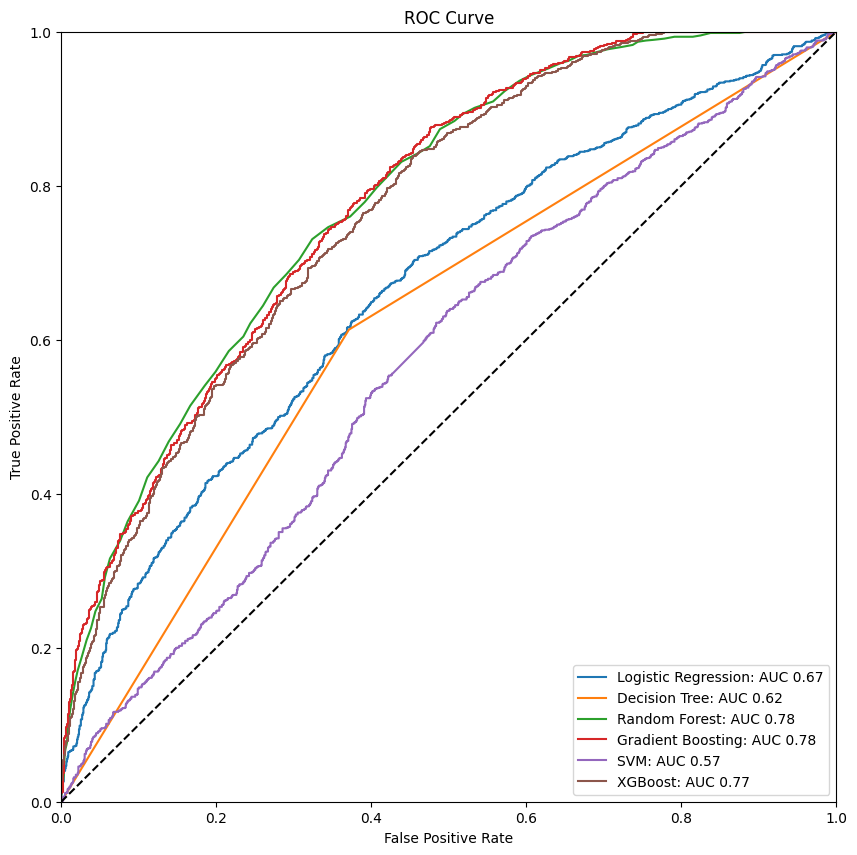

In [12]:
#for model in models add trace roc curve and auc score

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plot roc curve for each model
plt.figure(figsize=(10, 10))
for name, model in models_gpu.items():
    y_pred = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s: AUC %0.2f' % (name, roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#top 3 models
top_3_models = [comparison.sort_values(by='Accuracy', ascending=False).index[0],comparison.sort_values(by='Accuracy', ascending=False).index[1], comparison.sort_values(by='Accuracy', ascending=False).index[2]]
top_3_models

In [12]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import sys,os

#hyperparameter tuning of top 3 models from comparison table

# define the models to tune
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
}

# define the hyperparameters to tune
param_grid = {
    'Random Forest': {
        'n_estimators': [100, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': [1, 10, 50],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 500],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [10, 20, 50, 70],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [10, 100, 500],
        'learning_rate': [0.01, 0.1, 1, 10],
        'max_depth': [2, 6, 10, 20],
        'min_child_weight': [1, 3, 7, 9],
        'gamma': [0.25, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.005, 0.01, 0.05],
        'reg_lambda': [1, 2, 10]
    }
}


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
# define the function to tune the hyperparameters

def hyperparameter_tuning(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    return best_params, best_score


parameter_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best Score'])
rows = []

# tune the hyperparameters with a progress bar using tqdm
for name, model in tqdm(models.items()):
    print("Tuning hyperparameters for: ", name)
    best_params, best_score = hyperparameter_tuning(model, param_grid[name], X_train, y_train)
    print("Best params: ", best_params)
    print("Best score: ", best_score)
    print("")
    rows.append([name, best_params, best_score])
    
parameter_df = pd.DataFrame(rows, columns=['Model', 'Best Parameters', 'Best Score'])
print(parameter_df.sort_values(by='Best Score', ascending=False))

#save the dataframe to csv
parameter_df.to_csv('../src/data/processed/parameter_df.csv')

  0%|          | 0/2 [00:00<?, ?it/s]

Tuning hyperparameters for:  Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 50%|█████     | 1/2 [04:37<04:37, 277.21s/it]

Best params:  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.7457886773790664

Tuning hyperparameters for:  Gradient Boosting
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


100%|██████████| 2/2 [1:22:35<00:00, 2477.92s/it]

Best params:  {'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.7455145807662971

               Model                                    Best Parameters  \
0      Random Forest  {'criterion': 'entropy', 'max_depth': 50, 'min...   
1  Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 20, 'min_s...   

   Best Score  
0    0.745789  
1    0.745515  


In [15]:
#save the best model and his parameters

#get name of best model
best_model_name = parameter_df.sort_values(by='Best Score', ascending=False)['Model'].loc[0]
print("Best model: ", best_model_name)

#get the best parameters
best_params = parameter_df[parameter_df['Model'] == best_model_name]['Best Parameters'].values[0]
print("Best parameters: ", best_params)

# create the best model
best_model = models[best_model_name].set_params(**best_params)

# fit the best model
best_model.fit(X_train, y_train)

# save the model
import pickle
pickle.dump(best_model, open('../src/data/model/best_model.pkl', 'wb'))

# compress the model to save space
import gzip
import shutil
with open('../src/data/model/best_model.pkl', 'rb') as f_in:
    with gzip.open('best_model.pkl.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# delete the uncompressed model
import os
os.remove('../src/data/model/best_model.pkl')

Best model:  Random Forest
Best parameters:  {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [16]:
#load the dataframe from csv
parameter_df = pd.read_csv('../src/data/processed/parameter_df.csv', index_col=0)
parameter_df

,Model,Best Parameters,Best Score
0,Random Forest,"{'criterion': 'entropy', 'max_depth': 50, 'min...",0.702643
1,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 70, 'min_s...",0.695298
2,XGBoost,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'learn...",0.703969


In [16]:
#load best parameters from json file
import json

with open('../src/data/model/best_params.json') as f:
    best_params = json.load(f)

#train the models with best parameters

# define the models to train
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# save the model
import pickle
pickle.dump(best_model, open('../src/data/model/best_model.pkl', 'wb'))

# compress the model to save space
import gzip
import shutil
with open('../src/data/model/best_model.pkl', 'rb') as f_in:
    with gzip.open('best_model.pkl.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# delete the uncompressed model
import os
os.remove('../src/data/model/best_model.pkl')